In [86]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

In [87]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [88]:
all_batches_data = []
all_batches_labels = []

for i in range(1, 6):
    with open(f'cifar-10-batches-py/data_batch_{i}', 'rb') as f:
        dataset_dict = pickle.load(f, encoding='bytes')
        all_batches_data.append(dataset_dict[b'data'])
        all_batches_labels.append(dataset_dict[b'labels'])

stacked_data = np.vstack(all_batches_data)
stacked_labels = np.hstack(all_batches_labels)

data = torch.tensor(stacked_data, dtype=torch.float32).view(-1, 3, 32, 32).to(device) / 255.
labels = torch.tensor(stacked_labels, dtype=torch.long).to(device)

split_idx = int(0.8 * len(data))

x_train, x_valid = data[:split_idx], data[split_idx:]
y_train, y_valid = labels[:split_idx], labels[split_idx:]

In [89]:
print(x_train.shape)
print(x_train.device)

torch.Size([40000, 3, 32, 32])
mps:0


In [90]:
class ConvNet(nn.Module):
    def __init__(self, 
                 num_channels: int, 
                 num_classes: int, 
                 filters: list[int], 
                 activation: nn.Module = nn.ReLU
                 ):
        super().__init__()
        conv_layers = [
            nn.Conv2d(num_channels, filters[0], kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(filters[0]),
            activation()
        ]
        for i in range(len(filters)-1):
            conv_layers += [
                nn.Conv2d(filters[i], filters[i+1], kernel_size=3, stride=2, padding=1), 
                nn.BatchNorm2d(filters[i+1]),
                activation()
            ]
        
        conv_layers.append(nn.Conv2d(filters[-1], num_classes, kernel_size=3, stride=1, padding=1))
        self.conv_layers = nn.Sequential(*conv_layers)
        self.flatten = nn.Flatten()

    def forward(self, x):
        h = self.conv_layers(x)
        return self.flatten(h)


In [91]:
model = ConvNet(3, 10, [64, 128, 256, 512, 1024], nn.LeakyReLU).to(device)


In [92]:
model

ConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affin

In [93]:
def accuracy(y_pred, y):
    return (y_pred.argmax(dim=1) == y).float().mean()

def validate_model(model, valid_loader, loss_fn, all_valid_loss):
    model.eval()
    valid_loss = []
    valid_acc = []
    
    with torch.no_grad():
        for batch in valid_loader:
            x, y = batch
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            valid_loss.append(loss.item())
            valid_acc.append(accuracy(y_pred, y))
    
    all_valid_loss.append(sum(valid_loss) / len(valid_loss))
    
    return sum(valid_acc) / len(valid_acc)

def plot_loss(all_train_loss, all_valid_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(all_train_loss, label='Training Loss')
    plt.plot(all_valid_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def train_model(model: nn.Module,
                optim: torch.optim.Optimizer,
                loss_fn,
                train_loader,
                valid_loader,
                scheduler,
                epochs=10,
                batch_size=32,
                valid_every=1
                ):
    all_train_loss = []
    all_valid_loss = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = []
        
        for batch in train_loader:
            x, y = batch
            optim.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optim.step()
            train_loss.append(loss.item())
        
        all_train_loss.append(sum(train_loss) / len(train_loss))
        scheduler.step()
        
        if epoch % valid_every == 0:
            valid_acc = validate_model(model, valid_loader, loss_fn, all_valid_loss)
            print(
                f"Epoch {epoch}, Train Loss: {sum(train_loss) / len(train_loss)}, "
                f"Valid Loss: {all_valid_loss[-1]}, "
                f"Acc: {valid_acc}"
            )
    
    plot_loss(all_train_loss, all_valid_loss)


In [94]:
from torch.utils.data import Dataset, DataLoader

class CIFARCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_ds = CIFARCustomDataset(x_train, y_train)
valid_ds = CIFARCustomDataset(x_valid, y_valid)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True)

Epoch 0, Train Loss: 1.54993879070282, Valid Loss: 1.4466755494903834, Acc: 0.5118809938430786
Epoch 1, Train Loss: 1.1212590856075286, Valid Loss: 1.0383046288459827, Acc: 0.6341853141784668
Epoch 2, Train Loss: 0.9210480556249618, Valid Loss: 0.976235557668887, Acc: 0.6616413593292236
Epoch 3, Train Loss: 0.759395398402214, Valid Loss: 0.8921005822027834, Acc: 0.6950878500938416
Epoch 4, Train Loss: 0.5945361299991607, Valid Loss: 0.8303520711847007, Acc: 0.717851459980011
Epoch 5, Train Loss: 0.4230230466246605, Valid Loss: 0.8882425475044372, Acc: 0.7223442196846008
Epoch 6, Train Loss: 0.24883763288259506, Valid Loss: 0.9686998982970326, Acc: 0.7340255379676819
Epoch 7, Train Loss: 0.11780044359564781, Valid Loss: 1.066904456375506, Acc: 0.7467052936553955
Epoch 8, Train Loss: 0.05565413995441049, Valid Loss: 1.1323630368462005, Acc: 0.748302698135376
Epoch 9, Train Loss: 0.03216975157232955, Valid Loss: 1.12271008819056, Acc: 0.7505990266799927


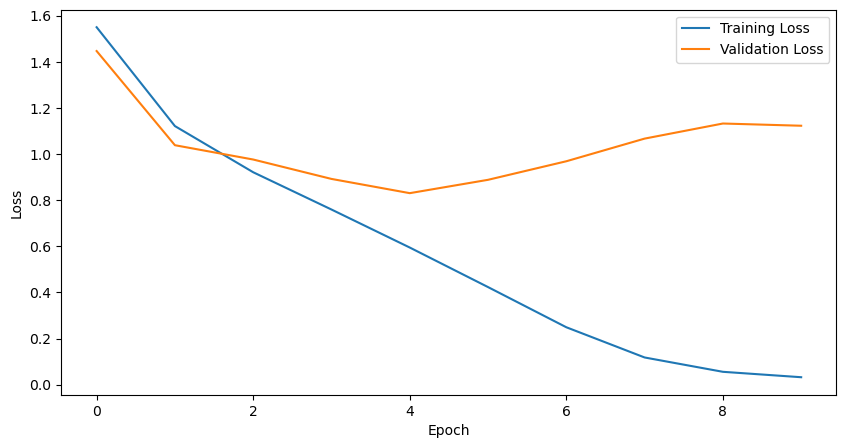

In [95]:
optim = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=10)
loss_fn = nn.CrossEntropyLoss()


train_model(model, optim, loss_fn, train_dl, valid_dl, scheduler=scheduler, epochs=10, valid_every=1)

In [96]:
class ConvBlock(nn.Module):
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 activation: nn.Module = nn.ReLU, 
                 kernel_size: int = 3, 
                 stride: int = 1, 
                 padding: int = 1
                 ):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding), 
            nn.BatchNorm2d(out_channels),
            activation(),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        return self.conv(x)

class ResBlock(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 activation: nn.Module = nn.ReLU, 
                 kernel_size: int = 3, 
                 stride: int = 1, 
                 padding: int = 1, 
                 dropout: float = 0.2
                 ):
        super().__init__()
        self.conv1 = ConvBlock(
            in_channels, 
            out_channels, 
            activation, 
            kernel_size, 
            stride, 
            padding
        )
        if in_channels == out_channels:
            self.idconv = nn.Identity()
        else:
            self.idconv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        
        self.avgpool = nn.Identity() if stride == 1 else nn.AvgPool2d(kernel_size=2, stride=stride)
        self.activation = activation()
        self.dropout = nn.Dropout(dropout)


    def forward(self, x):
        h = self.conv1(x)
        h_id = self.avgpool(self.idconv(x))
        return self.dropout(self.activation(h + h_id))



In [97]:
res_block = ResBlock(3, 64).to(device)
print(x_train[0].shape)
res_block(x_train[0].unsqueeze(0)).shape

for i in range(10):
    print(res_block(x_train[i].unsqueeze(0)).shape)


torch.Size([3, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])


In [98]:
class ResNet(nn.Module):
    def __init__(self,
                 num_channels: int,
                 num_classes: int,
                 filters: list[int],
                 activation: nn.Module = nn.ReLU,
                 stride: int = 2,
                 dropout: float = 0.2
                 ):
        super().__init__()
        res_layers = [
            ResBlock(num_channels, filters[0], activation, stride=1)
        ]
        for i in range(len(filters)-1):
            res_layers += [
                ResBlock(filters[i], filters[i+1], activation, stride=stride, dropout=dropout)
            ]
        self.res_layers = nn.Sequential(*res_layers)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(filters[-1], num_classes, bias=False),
            nn.BatchNorm1d(num_classes),
            activation()
        )
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        for _, layer in enumerate(self.res_layers):
            x = layer(x)

        h = self.avgpool(x)
        h = self.flatten(h)
        h = self.dropout(h)
        return self.linear(h)


In [99]:
model2 = ResNet(3, 10, [64, 128, 256, 256, 512], nn.ReLU, stride=2).to(device)
model2

ResNet(
  (res_layers): Sequential(
    (0): ResBlock(
      (conv1): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (idconv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (avgpool): Identity()
      (activation): ReLU()
      (dropout): Dropout2d(p=0.2, inplace=False)
    )
    (1): ResBlock(
      (conv1): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(128, 128, kernel_size=(3, 3), 

In [100]:
print(model.parameters())
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")
print(model2.parameters())
total_params = sum(p.numel() for p in model2.parameters())
print(f"Number of parameters: {total_params}")



<generator object Module.parameters at 0x481d33ca0>
Number of parameters: 6366730
<generator object Module.parameters at 0x481d33ca0>
Number of parameters: 6048724


/opt/homebrew/anaconda3/envs/fastai/lib/python3.10/site-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 0, Train Loss: 1.7134722347259521, Valid Loss: 1.347491905712091, Acc: 0.5643969774246216
Epoch 1, Train Loss: 1.4374918369293213, Valid Loss: 1.0795195154107797, Acc: 0.6376796960830688
Epoch 2, Train Loss: 1.1792907888889312, Valid Loss: 0.8506949332575447, Acc: 0.7078673839569092
Epoch 3, Train Loss: 0.9888795374155045, Valid Loss: 0.9592451224692713, Acc: 0.6729233264923096
Epoch 4, Train Loss: 0.8798450315713883, Valid Loss: 0.7114122538520886, Acc: 0.7512979507446289
Epoch 5, Train Loss: 0.7891853765249253, Valid Loss: 0.6539851950285153, Acc: 0.772963285446167
Epoch 6, Train Loss: 0.6946358621835709, Valid Loss: 0.5823333011077235, Acc: 0.8011181950569153
Epoch 7, Train Loss: 0.5777170667648316, Valid Loss: 0.5540082660345985, Acc: 0.8106030225753784
Epoch 8, Train Loss: 0.4382297728419304, Valid Loss: 0.5126438964955723, Acc: 0.8299720287322998
Epoch 9, Train Loss: 0.3083592665880919, Valid Loss: 0.5017434396444799, Acc: 0.8364616632461548


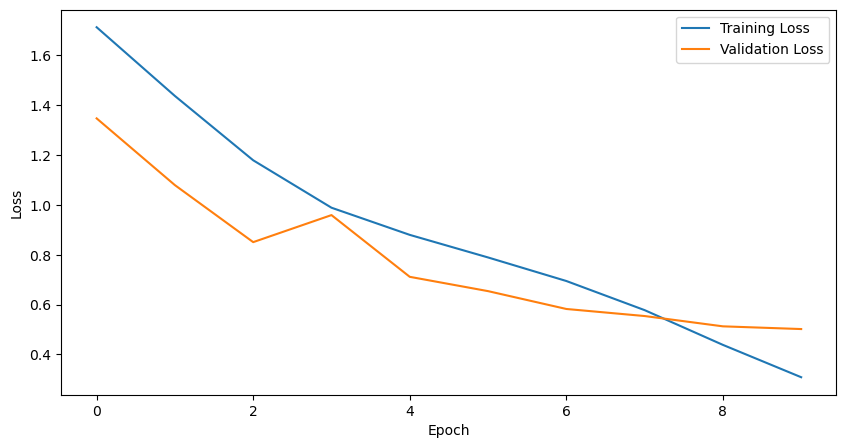

In [101]:
optim2 = torch.optim.Adam(model2.parameters(), lr=0.005, weight_decay=1e-5)
scheduler2 = torch.optim.lr_scheduler.OneCycleLR(optim2, max_lr=0.005, total_steps=12)
loss_fn = nn.CrossEntropyLoss()
train_model(model2, optim2, loss_fn, train_dl, valid_dl, scheduler=scheduler2, epochs=10, valid_every=1)

Since the model incorporates information from each resblock input into its output, you can make the model deeper and wider while improving learning and not losing too much information along the critical path. 

The resnet with less parameters 6M vs 6.5M still performs better on the validation set than the regular convnet. The resnet gets upto 85.5% accuracy vs 76.1% for the convnet. 

When we give the resnet as much width as out convnet, the number fo parameters rises to 19.5M. The improvement in validation accuracy, however, was marginal (85.9% vs 85.5%). 


Dropout strategy results (evalutated with the 6M parameter ResNet w/ same hyperparameters): 
1. Place after each conv block: 86% 
2. Place after each resblock: 87% -- loss still decreasing, we can still train more 
3. Place before the linear layer 85% 
4. After each resblock & before linear layer: 86.23%